## Problem
Clustering or grouping the documents based on the patterns and
similarities.

## Solution
Document clustering yet again includes similar steps, so let’s have a look at
them:

1. Tokenization

2. Stemming and lemmatization

3. Removing stop words and punctuation

4. Computing term frequencies or TF-IDF

5. Clustering: K-means/Hierarchical; we can then use
any of the clustering algorithms to cluster diﬀerent
documents based on the features we have generated

6. Evaluation and visualization: Finally, the clustering
results can be visualized by plotting the clusters into
a two-dimensional space

## Step 5-1 Import data and libraries
Here are the libraries, then the data:


In [2]:
!pip install mpld3
import numpy as np
import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS

In [5]:
#Lets use the same complaint dataset we use for classification
Data = pd.read_csv("D:\\workspace\data\\us-consumer-finance-complaint-database\\Consumer_Complaints.csv",encoding='latin-1')

#selecting required columns and rows
Data = Data[['consumer_complaint_narrative']]
Data = Data[pd.notnull(Data['consumer_complaint_narrative'])]

# lets do the clustering for just 200 documents. Its easier to interpret.
Data_sample=Data.sample(200)

## Step 5-2 Preprocessing and TF-IDF feature engineering

In [7]:
# Remove unwanted symbol
Data_sample['consumer_complaint_narrative'] = Data_sample['consumer_complaint_narrative'].str.replace('XXXX','')

# Convert dataframe to list
complaints = Data_sample['consumer_complaint_narrative'].tolist()

# create the rank of documents – we will use it later
ranks = []
for i in range(1, len(complaints)+1):
    ranks.append(i)

In [8]:
# Stop Words
stopwords = nltk.corpus.stopwords.words('english')

# Load 'stemmer'
stemmer = SnowballStemmer("english")

# Functions for sentence tokenizer, to remove numeric tokens and raw #punctuation
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for
    word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems
def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens
from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                    min_df=0.2, stop_words='english',
                                    use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

#fit the vectorizer to data
tfidf_matrix = tfidf_vectorizer.fit_transform(complaints)
terms = tfidf_vectorizer.get_feature_names()
print(tfidf_matrix.shape)

(200, 32)


## Step 5-3 Clustering using K-means
Let’s start the clustering:


In [10]:
#Import Kmeans
from sklearn.cluster import KMeans

# Define number of clusters
num_clusters = 6

#Running clustering algorithm
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

#final clusters
clusters = km.labels_.tolist()
complaints_data = { 'rank': ranks, 'complaints': complaints,'cluster': clusters }
frame = pd.DataFrame(complaints_data, index = [clusters] ,columns = ['rank', 'cluster'])

#number of docs per cluster
frame['cluster'].value_counts()

5    42
4    39
3    34
1    30
0    29
2    26
Name: cluster, dtype: int64

## Step 5-4 Identify cluster behavior
Identify which are the top 5 words that are nearest to the cluster centroid.


In [13]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in complaints:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

vocab_frame = pd.DataFrame({'words': totalvocab_tokenized},index = totalvocab_stemmed)

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end="")
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].
        values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()

Cluster 0 words: b'day', b'phone', b'company', b'time', b"n't", b'told',
Cluster 1 words: b'debt', b'collection', b'reported', b'company', b'requested', b'credit',
Cluster 2 words: b'received', b'pay', b'did', b'month', b'paid', b'credit',
Cluster 3 words: b'account', b'bank', b'informed', b'payment', b'letter', b'credit',
Cluster 4 words: b'credit', b'reported', b'credit', b'account', b'informed', b'file',
Cluster 5 words: b'loan', b'payment', b'month', b'making', b'sent', b'years',


D:\workspace\python\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


## Step 5-5 Plot the clusters on a 2D graph
Finally, we plot the clusters:

D:\workspace\python\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


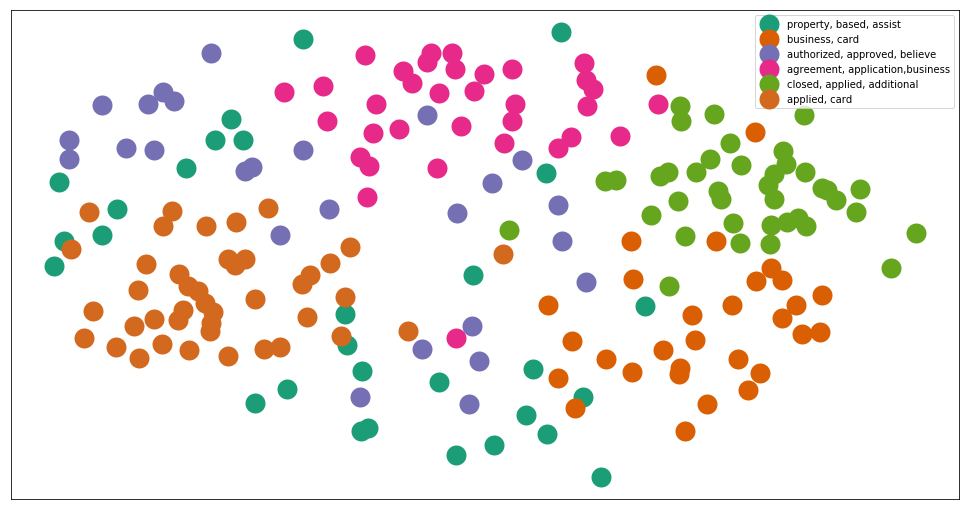

In [15]:
#Similarity
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

# Convert two components as we're plotting points in a two-dimensional plane
mds = MDS(n_components=2, dissimilarity="precomputed",random_state=1)
pos = mds.fit_transform(similarity_distance) # shape(n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

#Set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3',3: '#e7298a', 4: '#66a61e', 5: '#D2691E'}

#set up cluster names using a dict
cluster_names = {0: 'property, based, assist',
                 1: 'business, card',
                 2: 'authorized, approved, believe',
                 3: 'agreement, application,business',
                 4: 'closed, applied, additional',
                 5: 'applied, card'}

# Finally plot it
%matplotlib inline

#Create data frame that has the result of the MDS and the cluster
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters))
groups = df.groupby('label')

# Set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle="", ms=20,
            label=cluster_names[name], color=cluster_colors[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
            axis= 'x',
            which='both',
            bottom='off',
            top='off',
            labelbottom='off')
    ax.tick_params(\
            axis= 'y',
            which='both',
            left='off',
            top='off',
            labelleft='off')
ax.legend(numpoints=1)
plt.show()